In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
df = pd.read_csv('Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250527.csv')

In [4]:
numeric_cols = df.select_dtypes(include="number").columns
forecast_steps = 7
forecasts = {}

In [5]:
for col in numeric_cols:
    print(f"\nForecasting for {col}...")
    train_size = int(len(df) * 0.8)  
    train, test = df[col][:train_size], df[col][train_size:]
    # Fit ARIMA model
    model = sm.tsa.ARIMA(train, order=(5,1,0))  # Adjust (p,d,q) based on ACF/PACF plots
    model_fit = model.fit()
    # Forecast future values
    forecast = model_fit.forecast(steps=forecast_steps)
    forecasts[col] = forecast


Forecasting for Local Route...

Forecasting for Light Rail...

Forecasting for Peak Service...

Forecasting for Rapid Route...

Forecasting for School...

Forecasting for Other...


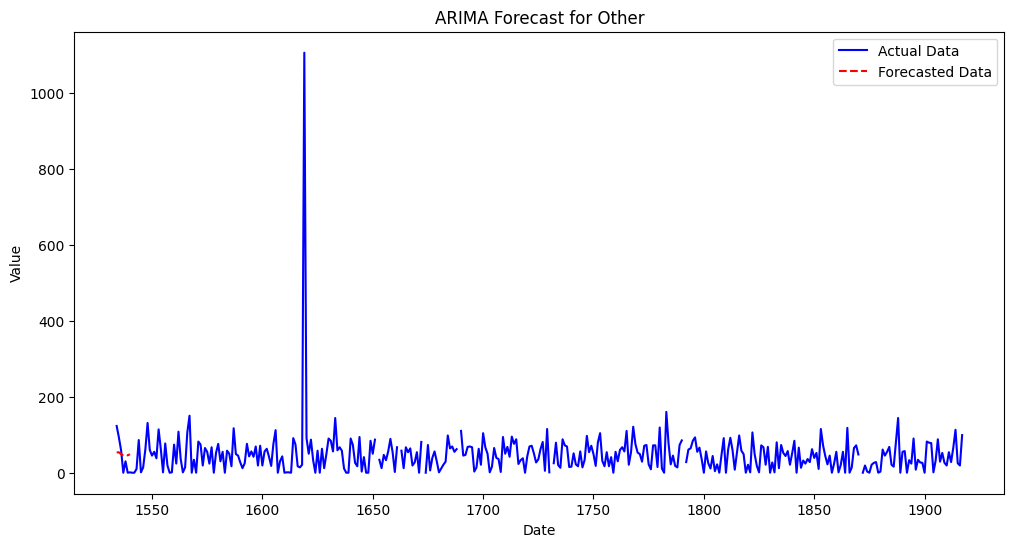

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Data", color="blue")
plt.plot(test.index[:forecast_steps], forecast, label="Forecasted Data", color="red", linestyle="dashed")
plt.title(f"ARIMA Forecast for {col}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

In [8]:
forecast_df = pd.DataFrame(forecasts)
print("\nForecasted Data for All Columns:")
print(forecast_df)


Forecasted Data for All Columns:
      Local Route   Light Rail  Peak Service   Rapid Route       School  \
1534  9842.985784  6939.768567    154.560774  12097.212712  2990.054209   
1535  9260.151703  6470.858985    135.237966  11356.235769  2934.715617   
1536  8068.058335  6087.932337    108.127338  10258.180077  2548.210537   
1537  7878.931207  6228.900935    101.309524  10440.007260  2442.290655   
1538  6993.635788  6088.435051     85.027732   9787.462282  1860.375327   
1539  7635.466574  6374.216157     95.184726  10428.784264  2062.004735   
1540  8249.724362  6359.826605    112.183031  10715.696714  2476.230217   

          Other  
1534  53.242998  
1535  53.802276  
1536  48.863794  
1537  46.234821  
1538  46.778438  
1539  45.740840  
1540  48.676740  


In [14]:
import numpy as np

# Compute error metrics
mae = mean_absolute_error(actual_values, forecast_values)
rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))  # Manually compute RMSE
mape = (abs(actual_values - forecast_values) / actual_values).mean() * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")  # RMSE correctly computed
print(f"MAPE: {mape:.2f}%")

if mape < 10:
    print("✅ Forecast is highly accurate! (MAPE < 10%)")
elif mape < 20:
    print("⚠️ Forecast is reasonably accurate (MAPE 10-20%)")
else:
    print("❌ Forecast is not very accurate (MAPE > 20%) – consider tuning ARIMA parameters.")


MAE: 4325.936339630499
RMSE: 5274.431565745186
MAPE: nan%
❌ Forecast is not very accurate (MAPE > 20%) – consider tuning ARIMA parameters.


In [15]:
# Compute variance for each numerical column
numeric_cols = df.select_dtypes(include="number").columns
variance_threshold = df[numeric_cols].var().mean()  # Define threshold as mean variance

# Identify high-variance columns
high_variance_cols = [col for col in numeric_cols if df[col].var() > variance_threshold]
print(f"High-variance columns: {high_variance_cols}")

High-variance columns: ['Local Route', 'Rapid Route']


In [19]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

In [20]:
# Apply transformations
for col in high_variance_cols:
    if df[col].min() > 0:  # Log transformation requires positive values
        df[col] = np.log1p(df[col])  # Log transformation
    else:
        pt = PowerTransformer(method="yeo-johnson")  # Box-Cox alternative for non-positive values
        df[col] = pt.fit_transform(df[[col]])

# Apply MinMax scaling to normalize transformed data
scaler = MinMaxScaler()
df[high_variance_cols] = scaler.fit_transform(df[high_variance_cols])

print("\nTransformed dataset:")
print(df.head())


Transformed dataset:
         Date  Local Route  Light Rail  Peak Service  Rapid Route  School  \
0  30/08/2024     0.987720       10705           225     0.760387    3925   
1  15/09/2023     0.984776       10671           267     0.744156    4519   
2  28/12/2021     0.862278        2352             0     0.257948       0   
3  11/01/2023     0.965005        8347           223     0.621669       0   
4  11/09/2021     0.811880         612             0     0.125101       0   

   Other  
0   59.0  
1   61.0  
2   13.0  
3   48.0  
4   11.0  


In [25]:
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.arima.model import ARIMA

In [26]:
# Define parameter grid
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)
param_grid = [(p, d, q) for p in p_values for d in d_values for q in q_values]

# Perform Grid Search
best_score, best_cfg = float("inf"), None
for param in param_grid:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        aic = model_fit.aic  # Akaike Information Criterion (lower is better)
        if aic < best_score:
            best_score, best_cfg = aic, param
    except:
        continue

print(f"Best ARIMA parameters: {best_cfg}")

C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-statio

Best ARIMA parameters: (3, 0, 2)


C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
# Apply first-order differencing to ensure stationarity
df["Local Route"] = df["Local Route"].diff().dropna()

# Fit ARIMA model with proper constraints
model = sm.tsa.ARIMA(train, order=(3,0,2), enforce_stationarity=True, enforce_invertibility=True)
model_fit = model.fit(method_kwargs={"maxiter": 500})  # Increase max iterations to help convergence

# Check model summary
print(model_fit.summary())


C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Lenovo\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g.

                               SARIMAX Results                                
Dep. Variable:                  Other   No. Observations:                 1534
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -7479.714
Date:                Tue, 27 May 2025   AIC                          14973.429
Time:                        12:04:36   BIC                          15010.778
Sample:                             0   HQIC                         14987.327
                               - 1534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.425      0.671      -0.003       0.002
ar.L1          0.0054      0.027      0.196      0.845      -0.048       0.059
ar.L2          0.0324      0.028      1.174      0.2